In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import scanpy_scripts as ss
import bbknn
import gc

np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
expr_cmap = ss.lib.expression_colormap()
ss.lib.set_figsize((4, 4))

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import sctk as sk

In [631]:
def plot_genes(ad, basis, genes, **kwargs):
    n = len(genes)
    ss.lib.set_figsize((2, 2))
    axs = ss.lib.plot_scatter(
        ad, basis=basis, ncols=12, wspace=0, hspace=0.2, show=False, color=genes, **kwargs
    )
    if n == 1:
        axs = [axs]
    for i, ax in enumerate(axs):
        ax.tick_params(which="both", bottom=False, top=False, left=False, right=False)
        ax.set_xlabel("")
        ax.set_ylabel("")
        plt.gcf().axes[-(i + 1)].remove()

In [195]:
def make_fig1(ad, name):
    ad.obs["annot1"] = ad.obs["annot"].str.replace("?", "")
    ad.obs["annot1"] = ad.obs["annot1"].astype("category")

    ss.lib.clear_colors(ad)
    ss.lib.highlight(
        ad,
        basis="umap_hm",
        groupby="annot1",
        figsize=(4, 4),
        size=20,
        wspace=0.5,
        hide_color="#DDDDDD50",
        groups={
            "organoid": list(
                ad.obs.annot1.cat.categories[ad.obs.annot1.cat.categories.str.startswith("org_")]
            ),
            "fetal": list(
                ad.obs.annot1.cat.categories[ad.obs.annot1.cat.categories.str.startswith("fsk_")]
            ),
        },
        show=False,
    )
    fig = plt.gcf()
    titles = ["Organoid", "Fetal skin"]
    for i, ax in enumerate(fig.axes):
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title(titles[i])
    fig.savefig(f"{name}.pdf", bbox_inches="tight")

In [458]:
def reprocess(
    ad,
    hvg_min_batch=1,
    batch=["dataset", "batch"],
    n_pcs=20,
    n_neighbors=15,
    remove_genes=["mito", "ribo", "cc"],
    **kwargs
):
    ad.var["cc"] = ad.var_names.isin(cc_genes)
    ad.var["mito"] = ad.var_names.str.startswith("MT-")
    ad.var["ribo"] = ad.var_names.str.startswith("RPS") | ad.var_names.str.startswith("RPL")

    ad1 = ss.lib.simple_default_pipeline(
        ad,
        batch=batch,
        post_norm_only=True,
        hvg_kw={"by_batch": ("dataset", hvg_min_batch)},
        pca_kw={"remove_genes": remove_genes},
        nb_kw={"n_pcs": n_pcs, "n_neighbors": n_neighbors},
        **kwargs
    )

    #     ss.lib.clear_colors(ad1)
    #     ss.lib.set_figsize((4, 4))
    #     ss.lib.plot_scatter(ad1, basis='umap_hm', ncols=5, size=40, color_map=expr_cmap, color=['CDK1', 'dataset', 'leiden_hm_r0_9', 'annot'])
    return ad1

In [371]:
def make_fig2(ad, name, marker_size=20, figsize=(4, 4)):
    ss.lib.clear_colors(ad)
    ads = ss.lib.split_by_group(ad, groupby="dataset")
    ss.lib.set_figsize((figsize[0] * 2, figsize[1]))
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, gridspec_kw={"wspace": 0})
    for i, subset in enumerate(("organoid", "fetal_skin")):
        ads[subset].obs["joint_annot"] = (
            ads[subset]
            .obs["joint_annot"]
            .astype(str)
            .astype(
                pd.CategoricalDtype(
                    categories=list(ad.obs.joint_annot.cat.categories), ordered=False
                )
            )
        )
        ss.lib.plot_embedding(
            ads[subset],
            basis="umap_hm",
            groupby="joint_annot",
            size=marker_size,
            show=False,
            annot=True,
            ax=axs[i],
            figsize=figsize,
        )
        axs[i].set_title(subset.capitalize().replace("_", " "))
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
    fig.savefig(f"{name}.pdf", bbox_inches="tight")
    del ads

In [596]:
def make_fig3(ad, name=None, marker_size=20, figsize=(4, 4), palette="viridis", **kwargs):
    ss.lib.clear_colors(ad)
    ads = ss.lib.split_by_group(ad, groupby="dataset")
    ss.lib.set_figsize((figsize[0] * 2, figsize[1]))
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, gridspec_kw={"wspace": 0})
    for i, subset in enumerate(("organoid", "fetal_skin")):
        ads[subset].obs["week"] = (
            ads[subset]
            .obs["week"]
            .astype(str)
            .astype(pd.CategoricalDtype(categories=list(ad.obs.week.cat.categories), ordered=False))
        )
        ss.lib.plot_scatter(
            ads[subset],
            basis="umap_hm",
            color="week",
            size=marker_size,
            show=False,
            ax=axs[i],
            palette=palette,
            **kwargs,
        )
        axs[i].set_title(subset.capitalize().replace("_", " "))
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
    if name:
        fig.savefig(f"{name}.pdf", bbox_inches="tight")
    del ads

In [2]:
sk_ad = sc.read("fetal_skin_bbknn.annotated.20200626.h5ad", backed="r")

Only considering the two last: ['.20200626', '.h5ad'].
Only considering the two last: ['.20200626', '.h5ad'].


In [4]:
fsk_annot_df = sk_ad.obs[["annotation"]].copy()

In [5]:
fsk_annot_df.head()

annotation
index                                                                   
AAACCTGGTCAGTGGA-1-4834STDY7002879                           Macrophage1
AAAGATGGTCGATTGT-1-4834STDY7002879  Monocyte (activated/differentiating)
AAAGCAAAGATGTGGC-1-4834STDY7002879                           Macrophage1
AAAGTAGCAGATCGGA-1-4834STDY7002879          Eo/baso/mast cell progenitor
AAAGTAGTCCGCATCT-1-4834STDY7002879                           Macrophage1

In [74]:
cc_genes = pd.read_csv("../data/misc/cc_genes.list", header=None, names=["gene"]).gene.to_list()

# KC

In [143]:
kc_pooled = sc.read("../20200427_organoid_integration/pooled_keratinocytes.processed.h5ad")

In [80]:
kc_pooled.var["cc"] = kc_pooled.var_names.isin(cc_genes)
kc_pooled.var["mito"] = kc_pooled.var_names.str.startswith("MT-")
kc_pooled.var["ribo"] = kc_pooled.var_names.str.startswith(
    "RPS"
) | kc_pooled.var_names.str.startswith("RPL")

In [123]:
kc_pooled1 = ss.lib.simple_default_pipeline(
    kc_pooled,
    batch=["dataset", "batch"],
    post_norm_only=True,
    hvg_kw={"by_batch": ("dataset", 1)},
    pca_kw={"remove_genes": ["mito", "ribo", "cc"]},
)

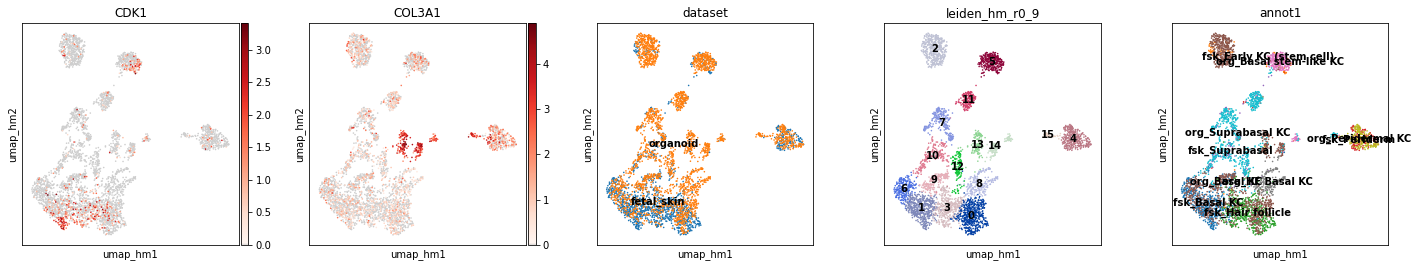

In [137]:
ss.lib.clear_colors(kc_pooled1)
ss.lib.set_figsize((4, 4))
ss.lib.plot_scatter(
    kc_pooled1,
    basis="umap_hm",
    color=["CDK1", "COL3A1", "dataset", "leiden_hm_r0_9", "annot1"],
    ncols=5,
    size=10,
    color_map=expr_cmap,
    legend_loc="on data",
)

In [139]:
kc_pooled2 = kc_pooled1[~kc_pooled1.obs.leiden_hm_r0_9.isin(["13", "14", "15"])].copy()

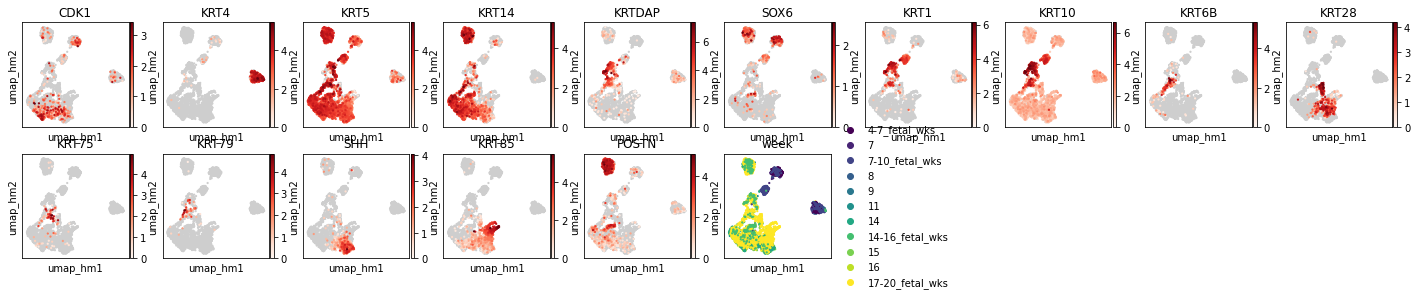

In [522]:
ss.lib.set_figsize((2, 2))
ss.lib.plot_scatter(
    kc_pooled2,
    basis="umap_hm",
    wspace=0.2,
    palette="viridis",
    color=[
        "CDK1",
        "KRT4",
        "KRT5",
        "KRT14",
        "KRTDAP",
        "SOX6",
        "KRT1",
        "KRT10",
        "KRT6B",
        "KRT28",
        "KRT75",
        "KRT79",
        "SHH",
        "KRT85",
        "POSTN",
        "week",
    ],
    ncols=10,
    size=20,
    color_map=expr_cmap,
)

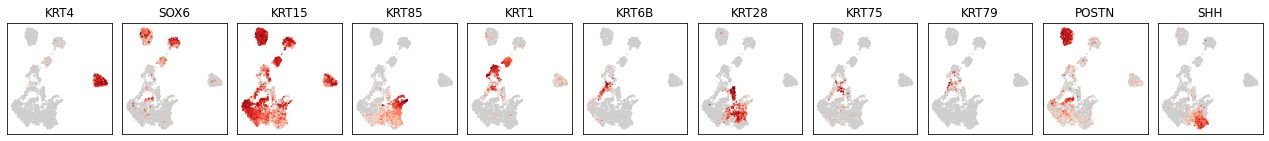

In [640]:
plot_genes(
    kc_pooled2,
    basis="umap_hm",
    color_map=expr_cmap,
    size=10,
    genes=[
        "KRT4",
        "SOX6",
        "KRT15",
        "KRT85",
        "KRT1",
        "KRT6B",
        "KRT28",
        "KRT75",
        "KRT79",
        "POSTN",
        "SHH",
    ],
)

In [261]:
ss.lib.leiden(
    kc_pooled2,
    use_graph="neighbors_hm",
    restrict_to=["leiden_hm_r0_9", ["10"]],
    resolution=0.3,
    key_added="hm_split1",
)

['leiden_hm_split1']

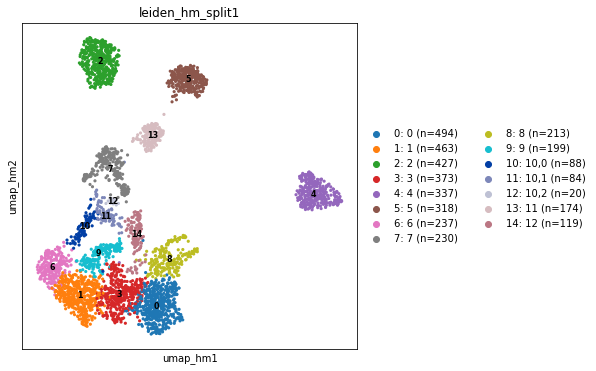

In [190]:
ss.lib.plot_embedding(
    kc_pooled2, basis="umap_hm", groupby="leiden_hm_split1", figsize=(6, 6), size=40
)

In [523]:
kc_pooled2.obs["joint_annot"] = ss.lib.regroup(
    kc_pooled2,
    groupby="leiden_hm_split1",
    regroups={
        "Periderm": "4",
        "Immature basal": "5",
        "Immature suprabasal": "11",
        "Basal": ["1", "3", "6", "9"],
        "Basal POSTN+": "2",
        "Basal SHH+": "0",
        "Cuticle/cortex": "8",
        "Outer root sheath": "10,0",
        "Inner root sheath": "12",
        "Companion layer": ["10,1", "10,2"],
        "Suprabasal IFE": "7",
    },
)

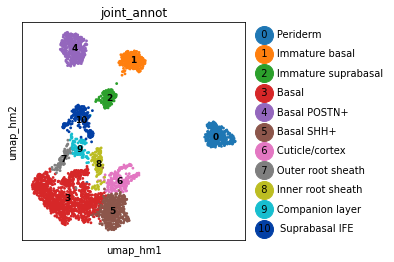

In [524]:
ss.lib.plot_embedding(kc_pooled2, basis="umap_hm", groupby="joint_annot")

In [626]:
celltypes = pd.Series(kc_pooled2.obs.annot.cat.categories)

In [627]:
fsk_celltypes = sorted(celltypes[celltypes.str.startswith("fsk_").values].to_list())

In [628]:
org_celltypes = sorted(celltypes[celltypes.str.startswith("org_").values].to_list())

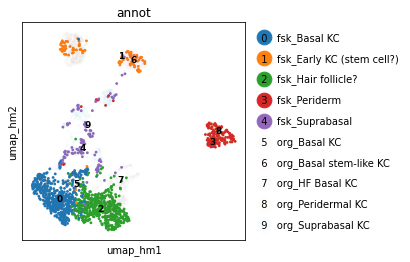

In [629]:
ss.lib.clear_colors(kc_pooled2)
ss.lib.plot_embedding(kc_pooled2, basis="umap_hm", groupby="annot", highlight=fsk_celltypes)

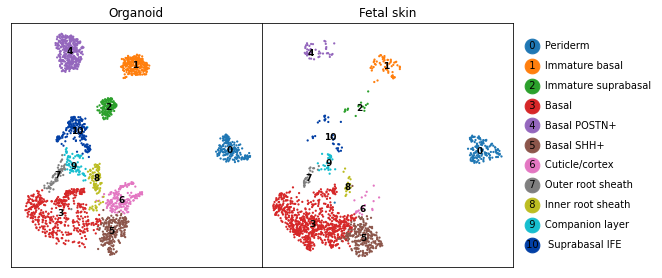

In [616]:
make_fig2(kc_pooled2, "kc_pooled", figsize=(4.5, 4.5))

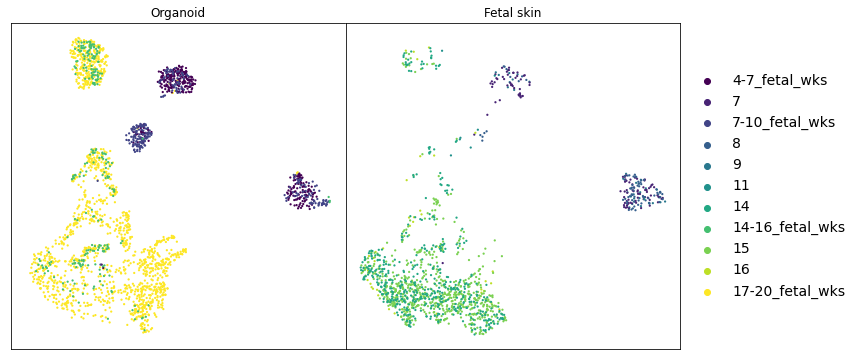

In [610]:
make_fig3(kc_pooled2, figsize=(6, 6), legend_fontsize=14)

In [554]:
kc_pooled2.var = kc_pooled2.var[
    [
        "gene_ids-fetal_skin",
        "hb-fetal_skin",
        "cc",
        "mito",
        "ribo",
        "n_counts",
        "n_cells",
        "highly_variable",
        "means",
        "dispersions",
        "dispersions_norm",
        "hvg_full",
    ]
].rename(columns={"gene_ids-fetal_skin": "gene_ids", "hb-fetal_skin": "hb"})

In [556]:
ss.lib.clear_colors(kc_pooled2)
kc_pooled2.write("pooled_keratinocytes.processed.h5ad", compression="lzf")

# Endothelium

In [244]:
et_pooled = sc.read("../20200427_organoid_integration/pooled_endothelium.processed.h5ad")

In [ ]:
et_pooled1 = reprocess(et_pooled)

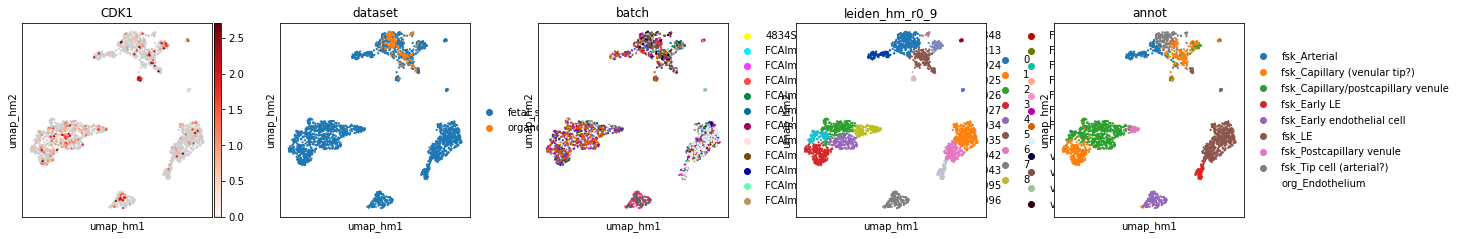

In [286]:
ss.lib.set_figsize((3.5, 3.5))
ss.lib.plot_scatter(
    et_pooled1,
    basis="umap_hm",
    ncols=5,
    size=20,
    color_map=expr_cmap,
    color=["CDK1", "dataset", "batch", "leiden_hm_r0_9", "annot"],
)

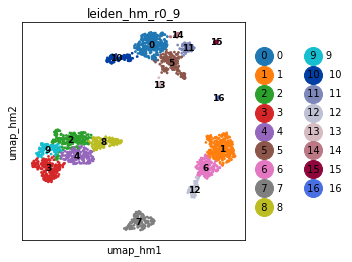

In [346]:
ss.lib.plot_embedding(
    et_pooled1, basis="umap_hm", size=30, groupby="leiden_hm_r0_9", figsize=(4, 4)
)

In [272]:
et_pooled2 = et_pooled1[~et_pooled1.obs.leiden_hm_r0_9.isin(["13", "14", "15", "16"])].copy()

In [331]:
ss.lib.simple_default_pipeline(et_pooled2, batch="batch", post_pca_only=True)

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


AnnData object with n_obs × n_vars = 2303 × 15445 
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'rachel_annot3', 'sample_id', 'strain', 'week', 'annot', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9'
    var: 'gene_ids-fetal_skin', 'cc-fetal_skin', 'mito-fetal_skin', 'ribo-fetal_skin', 'hb-fetal_skin', 'n_cells-fetal_skin', 'highly_variable-fetal_skin', 'means-fetal_skin', 'dispersions-fetal_skin', 'dispersions_norm-fetal_skin', 'highly_variable_nbatches-fetal_skin', 'highly_variable_intersection-fetal_skin', 'hvg_full-fetal_skin', 'gene_ids-organoid', 'gene_symbols-organoid', 'highly_variable-organoid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'cc', 'mito', 'ribo', 'n_counts', 'n_cells'
    uns: 'batch_colors', 'dataset_colors', 'leiden', 'neighbors_hm', 'pca', 'week_colors', 'neighbors'
    o

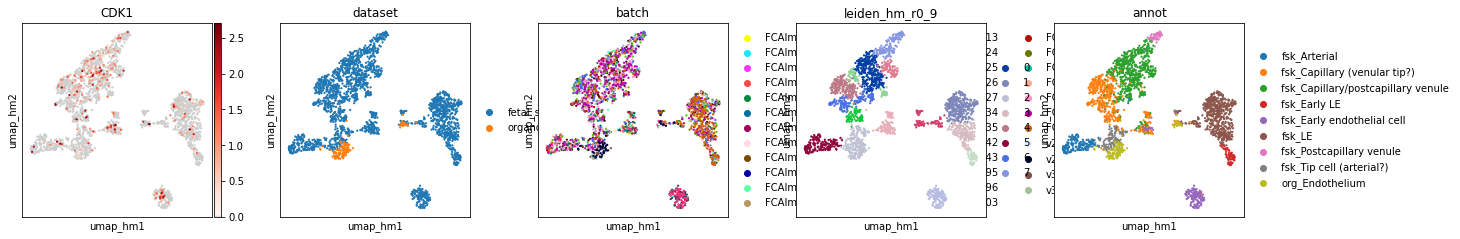

In [330]:
ss.lib.set_figsize((3.5, 3.5))
ss.lib.clear_colors(et_pooled2)
ss.lib.plot_scatter(
    et_pooled2,
    basis="umap_hm",
    ncols=5,
    size=20,
    color_map=expr_cmap,
    color=["CDK1", "dataset", "batch", "leiden_hm_r0_9", "annot"],
)

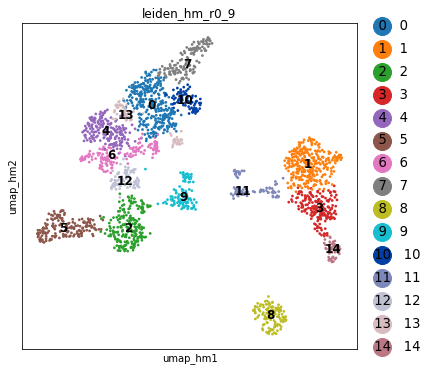

In [349]:
ss.lib.plot_embedding(
    et_pooled2,
    basis="umap_hm",
    size=30,
    groupby="leiden_hm_r0_9",
    figsize=(6, 6),
    legend_fontsize=12,
)

In [344]:
et_pooled3 = et_pooled2[~et_pooled2.obs.leiden_hm_r0_9.isin(["9", "11"])].copy()

In [347]:
ss.lib.cross_table(et_pooled3, "annot", "leiden_hm_r0_9", highlight=0)

In [350]:
et_pooled3.obs["joint_annot"] = ss.lib.regroup(
    et_pooled3,
    groupby="leiden_hm_r0_9",
    regroups={
        "Early endothelial cell": "8",
        "Early LE": "14",
        "LE": ["1", "3"],
        "Arterial": "5",
        "Tip cell (arterial)": "2",
        "Capillary (venular tip)": ["4", "6", "12"],
        "Capillary/postcapillary venule": ["0", "10", "13"],
        "Postcapillary venule": "7",
    },
)

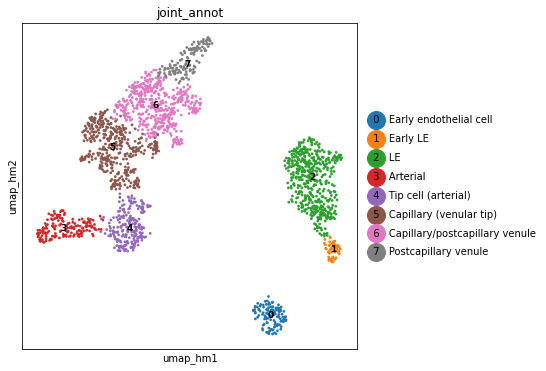

In [352]:
ss.lib.plot_embedding(et_pooled3, basis="umap_hm", size=30, groupby="joint_annot", figsize=(6, 6))

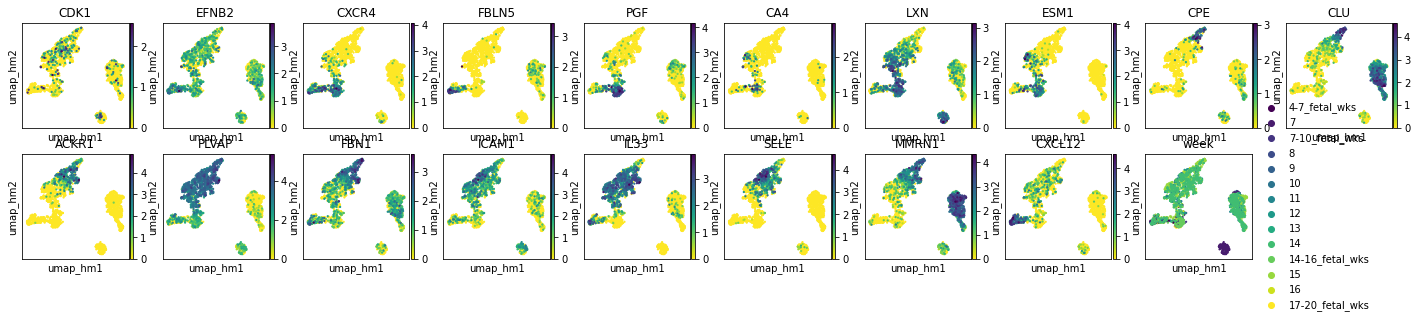

In [353]:
ss.lib.set_figsize((2, 2))
ss.lib.plot_scatter(
    et_pooled3,
    basis="umap_hm",
    wspace=0.2,
    palette="viridis",
    color=[
        "CDK1",
        "EFNB2",
        "CXCR4",
        "FBLN5",
        "PGF",
        "CA4",
        "LXN",
        "ESM1",
        "CPE",
        "CLU",
        "ACKR1",
        "PLVAP",
        "FBN1",
        "ICAM1",
        "IL33",
        "SELE",
        "MMRN1",
        "CXCL12",
        "week",
    ],
    ncols=10,
    size=20,
    color_map="viridis_r",
)

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


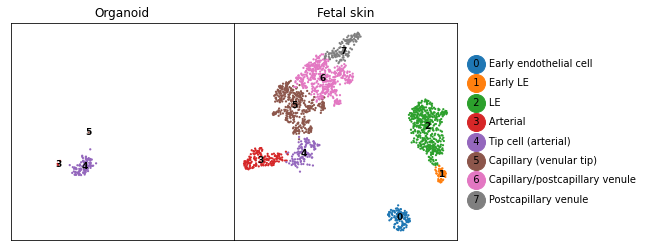

In [375]:
make_fig2(et_pooled3, "et_pooled", figsize=(4, 4))

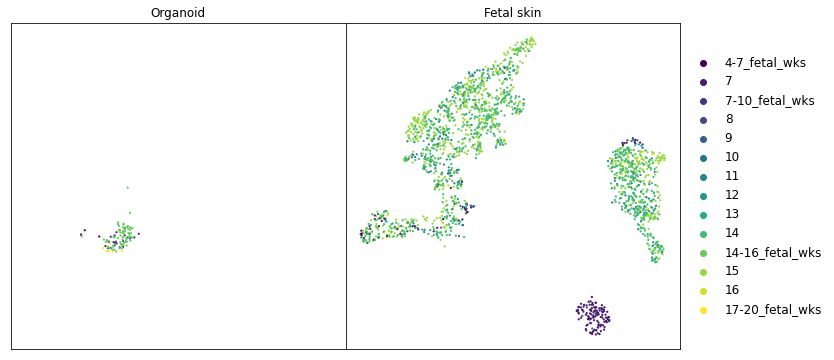

In [600]:
make_fig3(et_pooled3, figsize=(6, 6), legend_fontsize=12)

In [559]:
et_pooled3

AnnData object with n_obs × n_vars = 2048 × 14908 
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'rachel_annot3', 'sample_id', 'strain', 'week', 'annot', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', 'leiden_hm_split1', 'joint_annot', '__is_in_cluster__', 'leiden_r0_1', 'leiden_r0_3', 'leiden_r0_5', 'leiden_r0_7', 'leiden_r0_9'
    var: 'gene_ids', 'hb', 'cc', 'mito', 'ribo', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'hvg_full'
    uns: 'leiden', 'neighbors_hm', 'pca', 'rank_genes_groups_ja', 'rank_genes_groups_ja_filtered', 'dendrogram_joint_annot', 'rank_genes_groups_hm1', 'rank_genes_groups_hm1_filtered', 'rank_genes_groups_de.Capillary (venular tip)-Capillary (arterial tip)', 'rank_genes_groups_de.Capillary (venular tip)-Capillary (arterial tip)_filtered', 'rank_genes

In [558]:
et_pooled3.var = et_pooled3.var[
    [
        "gene_ids-fetal_skin",
        "hb-fetal_skin",
        "cc",
        "mito",
        "ribo",
        "n_counts",
        "n_cells",
        "highly_variable",
        "means",
        "dispersions",
        "dispersions_norm",
        "hvg_full",
    ]
].rename(columns={"gene_ids-fetal_skin": "gene_ids", "hb-fetal_skin": "hb"})

In [560]:
ss.lib.clear_colors(et_pooled3)
et_pooled3.write("pooled_endothelium.processed.h5ad", compression="lzf")

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/anndata/readwrite/write.py:308: UserWarning: Could not save field with key = 'uns/rank_genes_groups_ja_filtered/names' to hdf5 file: invalid literal for int() with base 10: ''
  .format(key, e)
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/anndata/readwrite/write.py:308: UserWarning: Could not save field with key = 'uns/rank_genes_groups_hm1_filtered/names' to hdf5 file: invalid literal for int() with base 10: ''
  .format(key, e)
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/anndata/readwrite/write.py:308: UserWarning: Could not save field with key = 'uns/rank_genes_groups_de.Capillary (venular tip)-Capillary (arterial tip)_filtered/names' to hdf5 file: invalid literal for int() with base 10: ''
  .format(key, e)
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/anndata/readwrite/write.py:308: UserWarning: Could not save field with key = 'uns/rank_genes_groups_de.Capillary (arteri

# Melanocytes

In [376]:
ml_pooled = sc.read("../20200427_organoid_integration/pooled_melanocytes.cellxgene.h5ad")

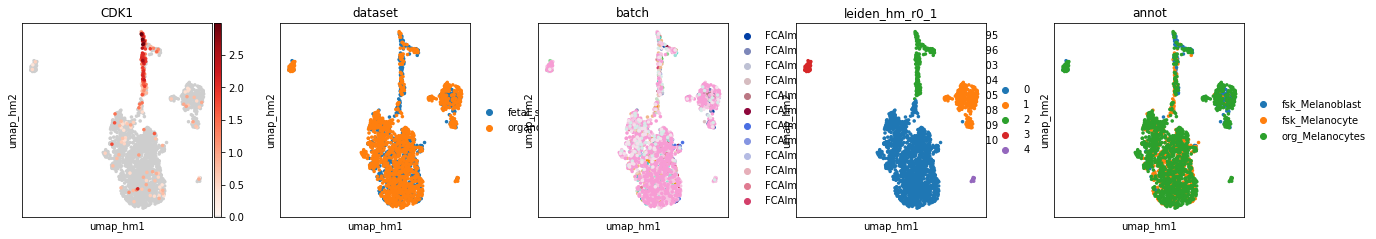

In [447]:
ss.lib.set_figsize((3.5, 3.5))
ss.lib.plot_scatter(
    ml_pooled,
    basis="umap_hm",
    ncols=5,
    size=50,
    color_map=expr_cmap,
    color=["CDK1", "dataset", "batch", "leiden_hm_r0_1", "annot"],
)

In [449]:
ml_pooled2 = ml_pooled[~ml_pooled.obs.leiden_hm_r0_1.isin(["3", "4"])].copy()

In [451]:
ml_pooled2.obs["joint_annot"] = ss.lib.regroup(
    ml_pooled2,
    groupby="leiden_hm_r0_1",
    regroups={
        "Melanoblasts": "1",
        "Proliferating melanoblasts": "2",
        "Melanocytes": "0",
    },
)

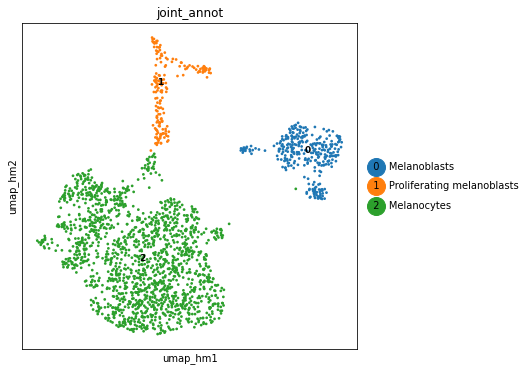

In [452]:
ss.lib.plot_embedding(ml_pooled2, basis="umap_hm", size=30, groupby="joint_annot", figsize=(6, 6))

In [444]:
ml_pooled1 = reprocess(
    ml_pooled, hvg_min_batch=2, n_pcs=5, n_neighbors=50, remove_genes=["mito", "ribo", "cc"]
)

ss.lib.set_figsize((3.5, 3.5))
ss.lib.plot_scatter(
    ml_pooled1[ml_pooled1.obs.dataset == "fetal_skin"],
    basis="umap_hm",
    ncols=5,
    size=50,
    color_map=expr_cmap,
    color=["CDK1", "dataset", "batch", "leiden_hm_r0_1", "annot"],
)

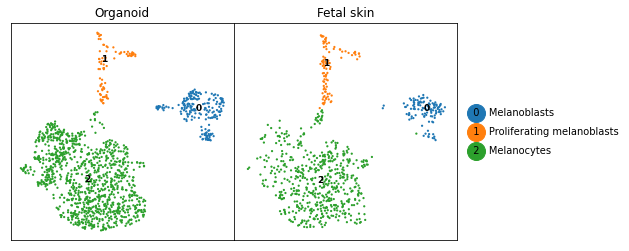

In [453]:
make_fig2(ml_pooled2, "ml_pooled", figsize=(4, 4))

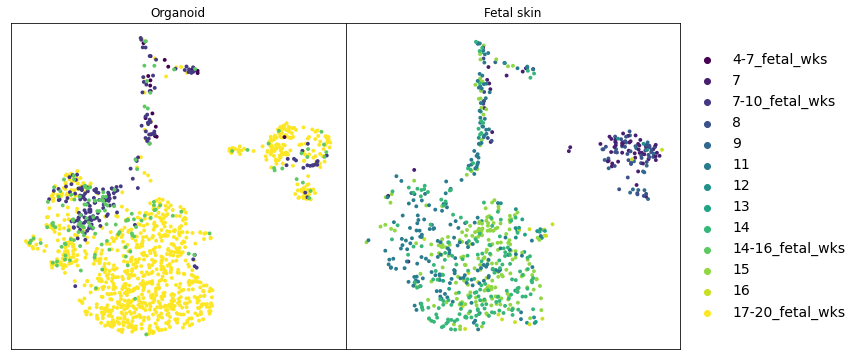

In [606]:
make_fig3(ml_pooled2, figsize=(6, 6), legend_fontsize=14, marker_size=60)

In [562]:
ss.lib.clear_colors(ml_pooled2)
ml_pooled2.write("pooled_melanocytes.processed.h5ad", compression="lzf")

# Neuronal

In [455]:
nr_pooled = sc.read("../20200427_organoid_integration/pooled_neuronal.processed.h5ad")

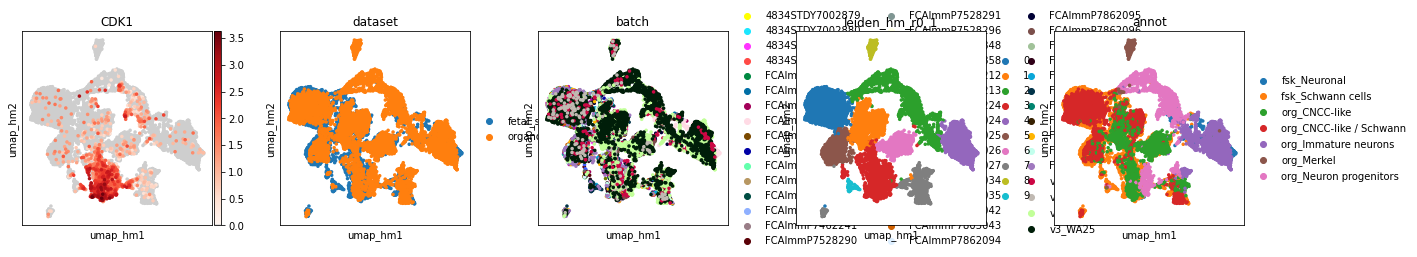

In [456]:
ss.lib.set_figsize((3.5, 3.5))
ss.lib.plot_scatter(
    nr_pooled,
    basis="umap_hm",
    ncols=5,
    size=30,
    color_map=expr_cmap,
    color=["CDK1", "dataset", "batch", "leiden_hm_r0_1", "annot"],
)

In [ ]:
nr_pooled1 = reprocess(nr_pooled)

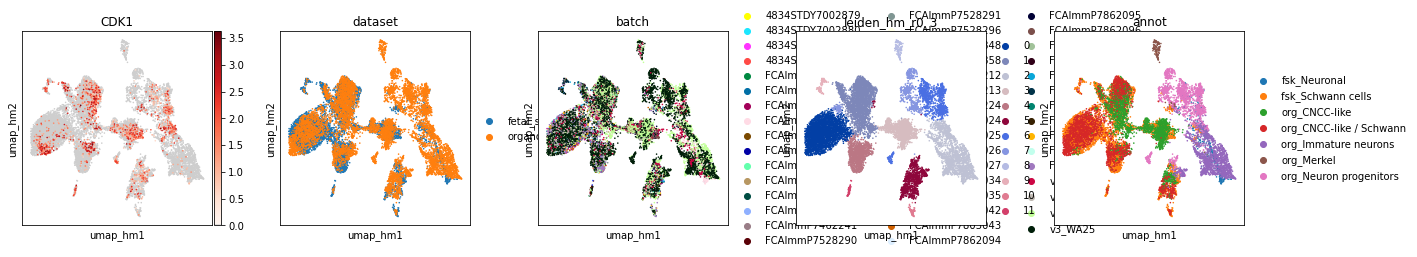

In [463]:
ss.lib.set_figsize((3.5, 3.5))
ss.lib.plot_scatter(
    nr_pooled1,
    basis="umap_hm",
    ncols=5,
    size=10,
    color_map=expr_cmap,
    color=["CDK1", "dataset", "batch", "leiden_hm_r0_3", "annot"],
)

In [20]:
nr_markers = [
    "STMN2",
    "DCX",
    "NEUROG1",
    "SPP1",
    "PDPN",
    "S100B",
    "S100A4",
    "APOD",
    "MBP",
    "PID1",
    "BCAN",
    "PAX6",
    "CP",
    "VASN",
    "PRRX1",
    "CDK1",
    "PCSK1N",
    "RGS5",
    "PTX3",
    "ASPA",
    "PCSK2",
]

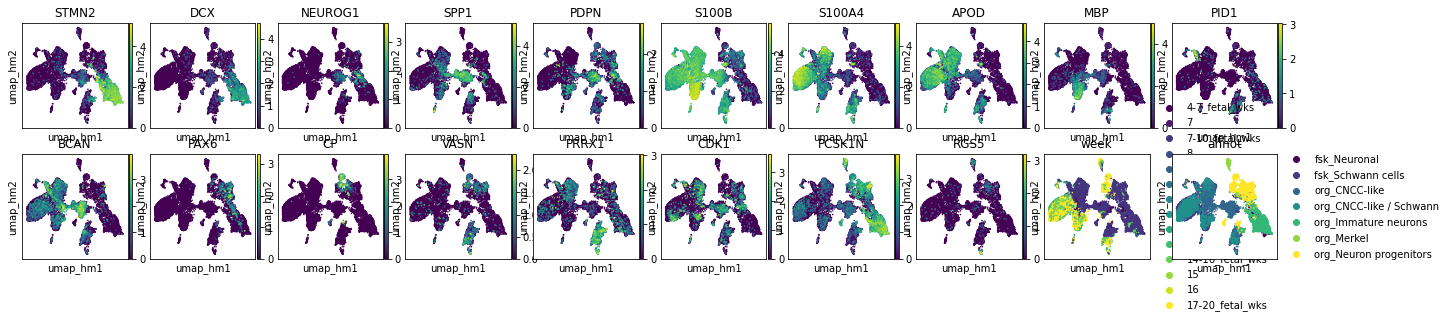

In [477]:
ss.lib.set_figsize((2, 2))
ss.lib.plot_genes(
    nr_pooled2,
    basis="umap_hm",
    wspace=0.1,
    ncols=10,
    size=10,
    color=nr_markers + ["week", "annot"],
    palette="viridis",
)

In [485]:
ss.lib.leiden(
    nr_pooled1,
    use_graph="neighbors_hm",
    restrict_to=["leiden_hm_r0_5", ["7"]],
    resolution=0.2,
    key_added="hm_split1",
)

['leiden_hm_split1']

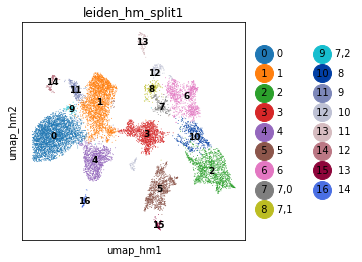

In [486]:
ss.lib.plot_embedding(
    nr_pooled1, basis="umap_hm", size=3, groupby="leiden_hm_split1", figsize=(4, 4)
)

In [491]:
nr_pooled2 = nr_pooled1[~nr_pooled1.obs.leiden_hm_r0_5.isin(["5", "10", "12", "13", "14"])].copy()

In [15]:
nr_pooled2.obs["joint_annot2"] = ss.lib.regroup(
    nr_pooled2,
    groupby="leiden_hm_split1",
    regroups={
        "Neuron progenitors": ["2", "8"],
        "Neuron progenitors SPP1+": "3",
        "Neuroepithelial cells": "6",
        "Secreting neuron": ["7,0", "7,1"],
        "Schwann precursors": ["1", "9"],
        "Non-myelinating schwann cells": ["0", "7,2"],
        "Myelinating Schwann cells": "4",
        "Merkel cells": "11",
    },
)

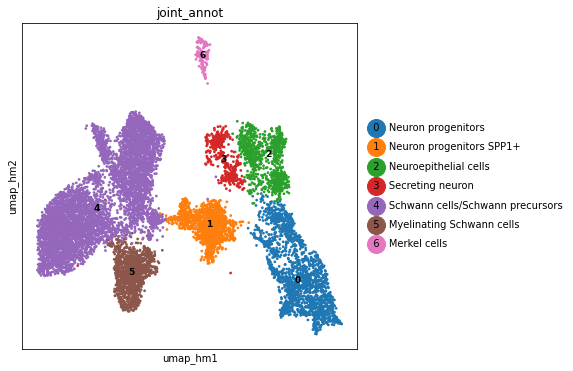

In [496]:
ss.lib.plot_embedding(nr_pooled2, basis="umap_hm", size=30, groupby="joint_annot", figsize=(6, 6))

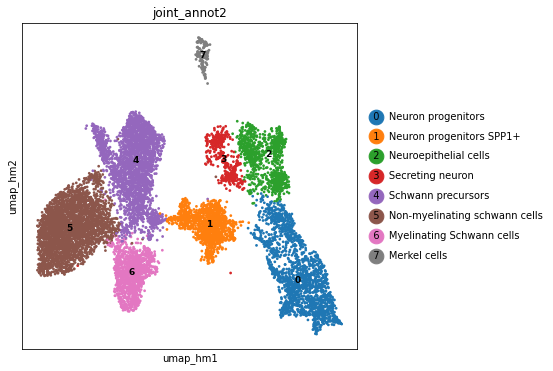

In [16]:
ss.lib.plot_embedding(nr_pooled2, basis="umap_hm", size=30, groupby="joint_annot2", figsize=(6, 6))

In [17]:
ss.lib.diffexp(
    nr_pooled2, groupby="joint_annot2", key_added="joint_annot2", filter_params=[0.5, 0.2, 1.5]
);

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


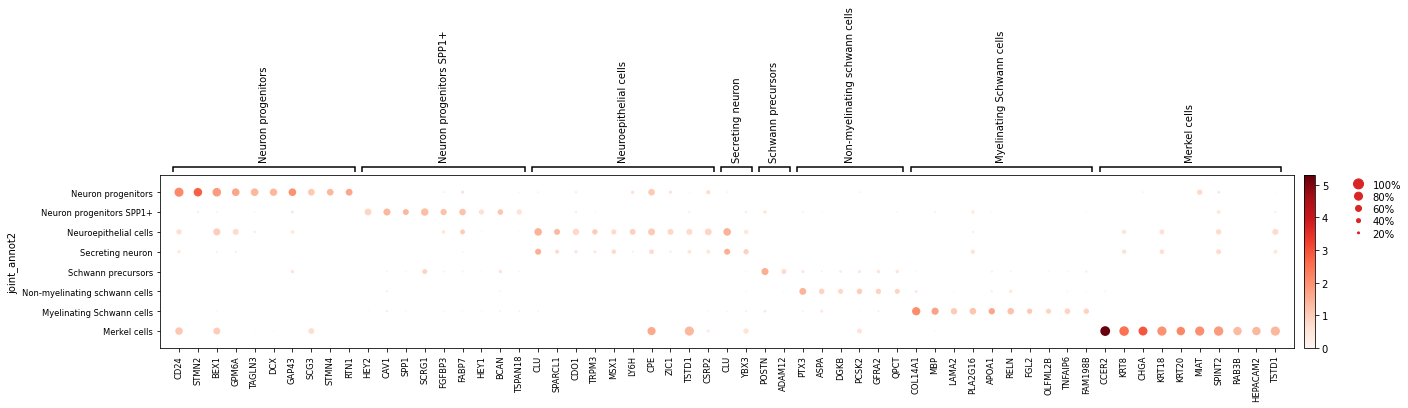

In [19]:
sc.pl.rank_genes_groups_dotplot(
    nr_pooled2,
    groupby="joint_annot2",
    key="rank_genes_groups_joint_annot2_filtered",
    dendrogram=False,
)

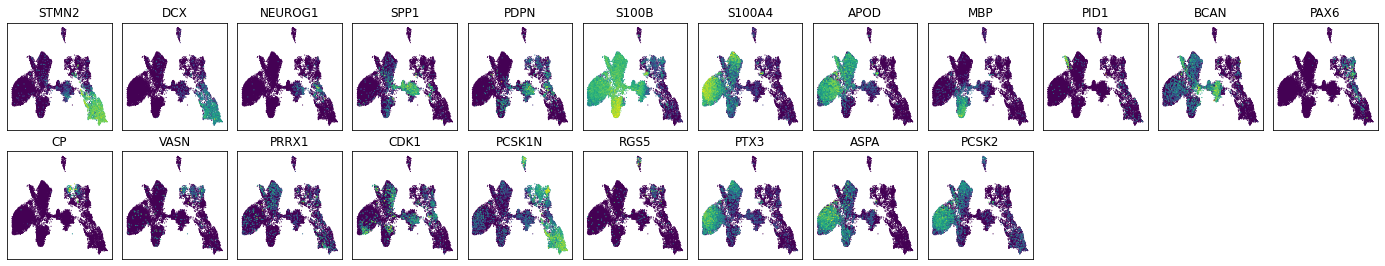

In [21]:
ss.lib.plot_genes(nr_pooled2, basis="umap_hm", genes=nr_markers, size=5)

In [ ]:
sc.pl.stacked_violin(nr_pooled2, groupby="joint_annot")

In [644]:
nr_pooled2

AnnData object with n_obs × n_vars = 11871 × 17663 
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'rachel_annot2', 'sample_id', 'strain', 'week', 'annot', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', '__is_in_cluster__', 'leiden_hm_split1', 'joint_annot'
    var: 'gene_ids', 'hb', 'cc', 'mito', 'ribo', 'n_counts', 'n_cells', 'highly_variable', 'hvg_full'
    uns: 'leiden', 'neighbors_hm', 'pca', 'rank_genes_groups', 'rank_genes_groups_filtered', 'neighbors'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm'
    varm: 'PCs'

In [ ]:
nr_pooled2s = ss.lib.subsample(nr_pooled2, 0.5, groupby)

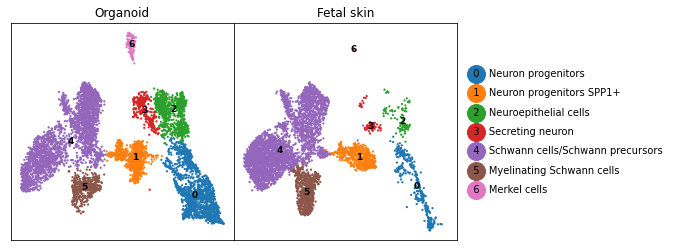

In [497]:
make_fig2(nr_pooled2, "nr_pooled", figsize=(4, 4))

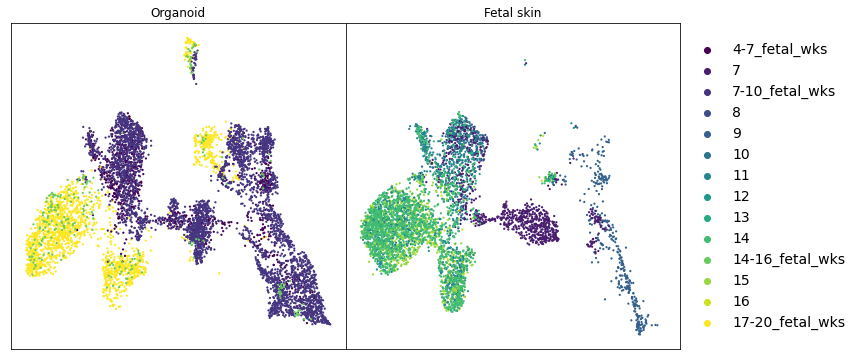

In [607]:
make_fig3(nr_pooled2, figsize=(6, 6), legend_fontsize=14)

In [563]:
nr_pooled2

AnnData object with n_obs × n_vars = 11871 × 17663 
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'rachel_annot2', 'sample_id', 'strain', 'week', 'annot', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', '__is_in_cluster__', 'leiden_hm_split1', 'joint_annot'
    var: 'gene_ids-fetal_skin', 'cc-fetal_skin', 'mito-fetal_skin', 'ribo-fetal_skin', 'hb-fetal_skin', 'n_cells-fetal_skin', 'highly_variable-fetal_skin', 'means-fetal_skin', 'dispersions-fetal_skin', 'dispersions_norm-fetal_skin', 'highly_variable_nbatches-fetal_skin', 'highly_variable_intersection-fetal_skin', 'hvg_full-fetal_skin', 'gene_ids-0-organoid', 'gene_symbols-0-organoid', 'highly_variable-0-organoid', 'gene_ids-1-organoid', 'gene_symbols-1-organoid', 'highly_variable-1-organoid', 'highly_variable', 'cc', 'mito', 'ribo', 'n_counts', 'n_cells', 'hvg_ful

In [566]:
nr_pooled2.var = nr_pooled2.var[
    [
        "gene_ids-fetal_skin",
        "hb-fetal_skin",
        "cc",
        "mito",
        "ribo",
        "n_counts",
        "n_cells",
        "highly_variable",
        "hvg_full",
    ]
].rename(columns={"gene_ids-fetal_skin": "gene_ids", "hb-fetal_skin": "hb"})

In [567]:
ss.lib.clear_colors(nr_pooled2)
nr_pooled2.write("pooled_neuronal.processed.h5ad", compression="lzf")

In [2]:
nr_pooled2 = sc.read("pooled_neuronal.processed.h5ad")

# Mesenchymal

In [498]:
st_pooled = sc.read("../20200427_organoid_integration/pooled_stroma.processed.h5ad")

In [499]:
gc.collect()

137241

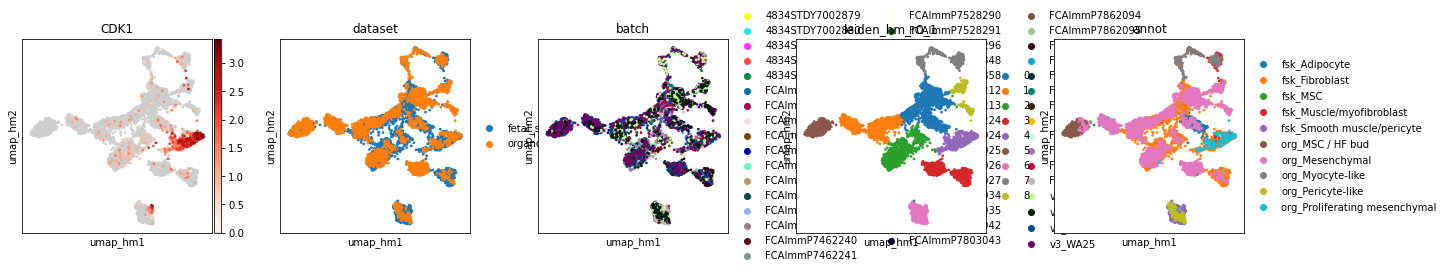

In [500]:
ss.lib.set_figsize((3.5, 3.5))
ss.lib.plot_scatter(
    st_pooled,
    basis="umap_hm",
    ncols=5,
    size=30,
    color_map=expr_cmap,
    color=["CDK1", "dataset", "batch", "leiden_hm_r0_1", "annot"],
)

In [503]:
st_pooled1 = reprocess(st_pooled)

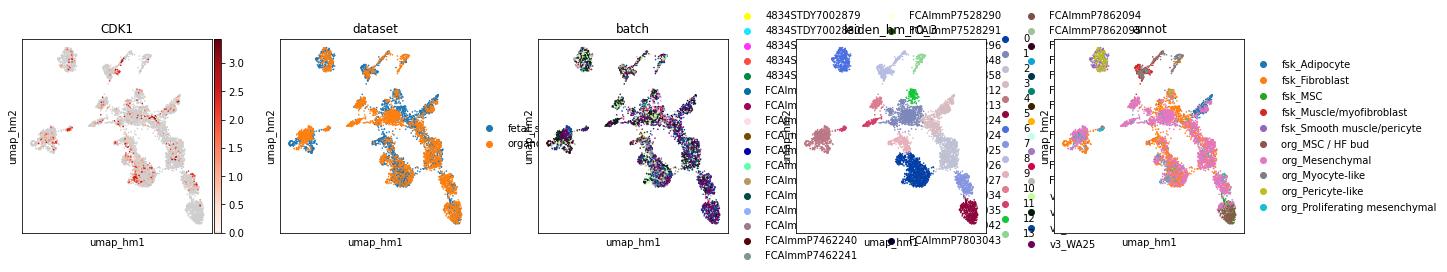

In [504]:
ss.lib.set_figsize((3.5, 3.5))
ss.lib.plot_scatter(
    st_pooled1,
    basis="umap_hm",
    ncols=5,
    size=10,
    color_map=expr_cmap,
    color=["CDK1", "dataset", "batch", "leiden_hm_r0_3", "annot"],
)

In [544]:
st_markers = [
    "CDK1",
    "HOXC5",
    "WNT2",
    "POSTN",
    "FRZB",
    "PTN",
    "PITX2",
    "PTCH2",
    "SOX2",
    "ACTG2",
    "SCN7A",
    "PLN",
    "RGS5",
    "PAX7",
    "MYOG",
    "MYH3",
    "LPL",
    "TWIST2",
]

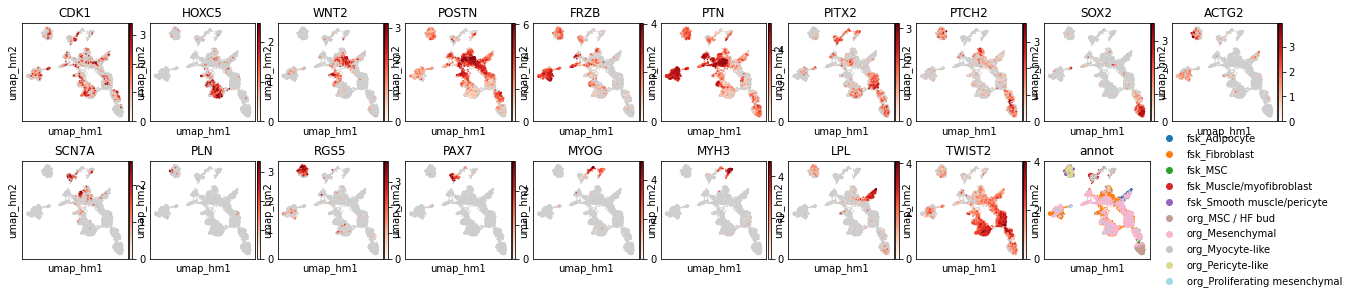

In [545]:
ss.lib.set_figsize((2, 2))
ss.lib.plot_scatter(
    st_pooled1,
    basis="umap_hm",
    hspace=0.4,
    wspace=0.1,
    ncols=10,
    size=10,
    color=st_markers + ["annot"],
    palette="tab20",
    color_map=expr_cmap,
)

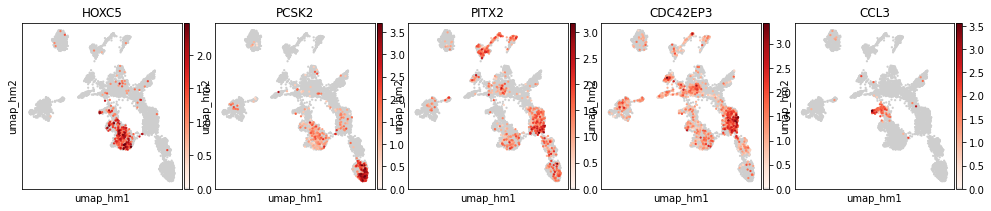

In [550]:
ss.lib.set_figsize((3, 3))
ss.lib.plot_scatter(
    st_pooled1,
    basis="umap_hm",
    hspace=0.4,
    wspace=0.1,
    ncols=6,
    size=20,
    color=["HOXC5", "PCSK2", "PITX2", "CDC42EP3", "CCL3"],
    color_map=expr_cmap,
)

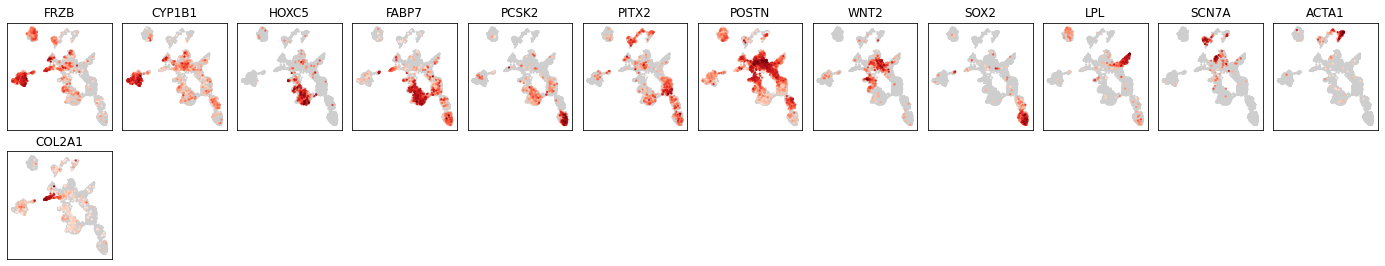

In [649]:
plot_genes(
    st_pooled1,
    basis="umap_hm",
    genes=[
        "FRZB",
        "CYP1B1",
        "HOXC5",
        "FABP7",
        "PCSK2",
        "PITX2",
        "POSTN",
        "WNT2",
        "SOX2",
        "LPL",
        "SCN7A",
        "ACTA1",
        "COL2A1",
    ],
    color_map=expr_cmap,
)

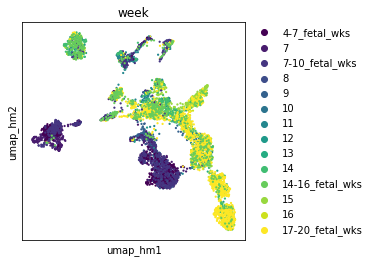

In [531]:
ss.lib.plot_scatter(st_pooled1, basis="umap_hm", size=20, color="week", palette="viridis")

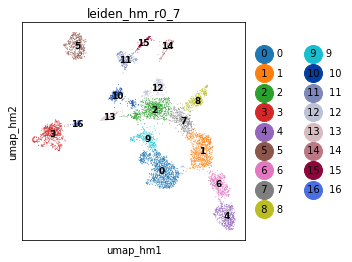

In [520]:
ss.lib.plot_embedding(st_pooled1, basis="umap_hm", size=3, groupby="leiden_hm_r0_7", figsize=(4, 4))

In [485]:
ss.lib.leiden(
    st_pooled1,
    use_graph="neighbors_hm",
    restrict_to=["leiden_hm_r0_5", ["7"]],
    resolution=0.2,
    key_added="hm_split1",
)

ss.lib.plot_embedding(
    st_pooled1, basis="umap_hm", size=3, groupby="leiden_hm_split1", figsize=(4, 4)
)

In [521]:
st_pooled2 = st_pooled1

In [546]:
st_pooled2.obs["joint_annot"] = ss.lib.regroup(
    st_pooled2,
    groupby="leiden_hm_r0_7",
    regroups={
        "Early fibroblasts HOXC5": "0",
        "Early fibroblasts FRZB+": ["3", "16"],
        "Fibroblasts POSTN+": ["2", "7", "9", "10", "12", "13"],
        "Pre-dermal condensate": "1",
        "Dermal condensate": "6",
        "Dermal papillia": "4",
        "Adipocytes": "8",
        "Smooth muscle/Pericytes": "5",
        "Myoblasts": "11",
        "Early myocytes": "15",
        "Myocytes": "14",
    },
)

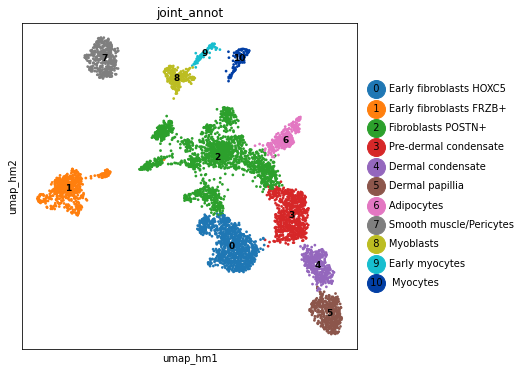

In [547]:
ss.lib.plot_embedding(st_pooled2, basis="umap_hm", size=30, groupby="joint_annot", figsize=(6, 6))

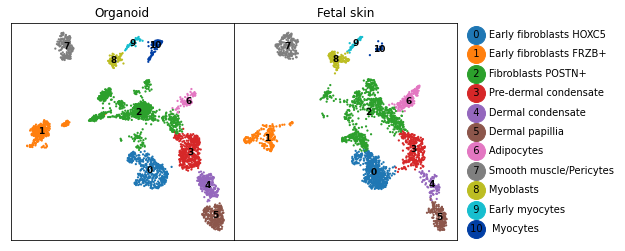

In [548]:
make_fig2(st_pooled2, "st_pooled", figsize=(4, 4))

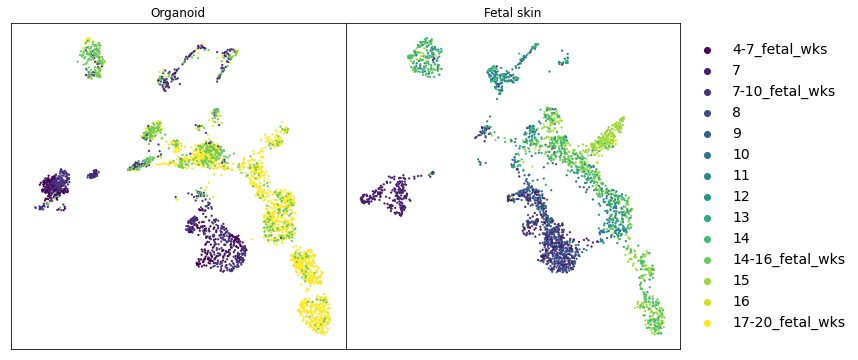

In [608]:
make_fig3(st_pooled2, figsize=(6, 6), legend_fontsize=14)

In [568]:
st_pooled2

AnnData object with n_obs × n_vars = 6213 × 16797 
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'rachel_annot2', 'sample_id', 'strain', 'week', 'annot', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', 'joint_annot'
    var: 'gene_ids-fetal_skin', 'cc-fetal_skin', 'mito-fetal_skin', 'ribo-fetal_skin', 'hb-fetal_skin', 'n_cells-fetal_skin', 'highly_variable-fetal_skin', 'means-fetal_skin', 'dispersions-fetal_skin', 'dispersions_norm-fetal_skin', 'highly_variable_nbatches-fetal_skin', 'highly_variable_intersection-fetal_skin', 'hvg_full-fetal_skin', 'gene_ids-organoid', 'gene_symbols-organoid', 'highly_variable-organoid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'cc', 'mito', 'ribo', 'n_counts', 'n_cells', 'hvg_full'
    uns: 'leiden', 'neighbors_hm', 'pca', 'neighbors'
    obsm: 'X_pca', 'X_pca_h

In [569]:
st_pooled2.var = st_pooled2.var[
    [
        "gene_ids-fetal_skin",
        "hb-fetal_skin",
        "cc",
        "mito",
        "ribo",
        "n_counts",
        "n_cells",
        "highly_variable",
        "hvg_full",
    ]
].rename(columns={"gene_ids-fetal_skin": "gene_ids", "hb-fetal_skin": "hb"})

In [570]:
ss.lib.clear_colors(st_pooled2)
st_pooled2.write("pooled_mesenchymal.processed.h5ad", compression="lzf")

In [3]:
st_pooled2 = sc.read("pooled_mesenchymal.processed.h5ad")

In [7]:
st_pooled2.obs.dataset.value_counts()

organoid      3365
fetal_skin    2848
Name: dataset, dtype: int64

In [14]:
st_pooled2.obs.joint_annot.cat.cattegories

Index(['Early fibroblasts HOXC5', 'Early fibroblasts FRZB+',
       'Fibroblasts POSTN+', 'Pre-dermal condensate', 'Dermal condensate',
       'Dermal papillia', 'Adipocytes', 'Smooth muscle/Pericytes', 'Myoblasts',
       'Early myocytes', 'Myocytes'],
      dtype='object')

In [15]:
st_pooled_ct_colors = [
    "#BB7784",
    "#D6BDC1",
    "#4B67AF",
    "#EAD3C7",
    "#7C87B9",
    "#BFC1D4",
    "#154496",
    "#C7DFC7",
    # "#8794CA",
    "#E6AFBA",
    "#8F143E",
    "#E07B91",
]

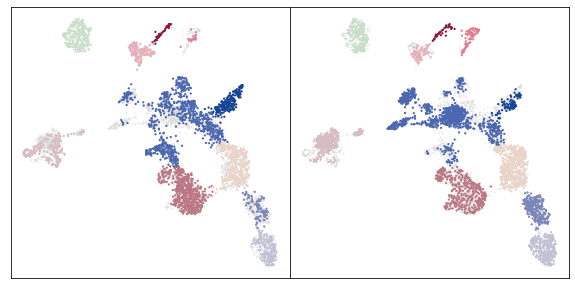

In [17]:
gc.collect()
sk.clear_colors(st_pooled2)
st_pooled2.uns["joint_annot_colors"] = st_pooled_ct_colors
sk.set_figsize((10, 5))
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, gridspec_kw={"wspace": 0})
sc.plotting._tools.plot_scatter(
    st_pooled2, basis="umap_hm", show=False, ax=ax[0], size=10, alpha=0.5
)
sk.plot_embedding(
    st_pooled2[st_pooled2.obs.dataset == "fetal_skin"],
    basis="umap_hm",
    groupby="joint_annot",
    annot="none",
    ax=ax[0],
    size=20,
)
sc.plotting._tools.plot_scatter(
    st_pooled2, basis="umap_hm", show=False, ax=ax[1], size=10, alpha=0.5
)
sk.plot_embedding(
    st_pooled2[st_pooled2.obs.dataset == "organoid"],
    basis="umap_hm",
    groupby="joint_annot",
    annot="none",
    ax=ax[1],
    size=20,
)
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[1].set_xlabel("")
ax[1].set_ylabel("");